In [1]:
# Core
import re, os, sys, string, random, functools
import pandas as pd
from pathlib import Path
import numpy as np
# Plotting
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
import seaborn as sns
# Stats
import scipy.stats as stats
import scikit_posthocs as skph
import statsmodels.api as sm
# Reduce warnings
import warnings
warnings.filterwarnings("ignore") # usually not a good idea!

In [2]:
def normal_test(x, alpha=0.05, log=False):   
    if log:
        x = np.log(x)
    k2, p = stats.normaltest(x)

    if p < alpha:
         print("The null hypothesis can be rejected (p = {:g}; alpha = {}). Data are non-normal.".format(p, alpha))
    else:
         print("The null hypothesis cannot be rejected (p = {:g}; alpha = {}). Data are normal.".format(p, alpha))
    return k2, p

In [3]:
def getIndexMax(a):
    return max(range(len(a)), key=a.__getitem__)

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

## Some basic stats
First I'll load the data and look into some correlations and investigate possible group differences.

In [5]:
morpho = pd.read_csv("../Data/All-morphological-data.csv")
morpho.head()

,MajorLineage,Taxon,Tissue,Pathway,MAmean (um^2),LTmean (um),IASmean (%),LDMCmean (g/g),LDMCse (g/g),dSLAmean (mm^2/mg),dSLAse (mm^2/mg),fSLAmean (mm^2/mg),fSLAse (mm^2/mg),CAMpheno,CAMphenoCat,Reference,Genus,Species,color
0,Acanthaceae,Acanthopsis disperma,leaf,C3,NaN,NaN,NaN,NaN,NaN,5.219207,NaN,NaN,NaN,non-CAM,0,"Cornwell WK, Wright I, Turner J, Maire V, Barb...",Acanthopsis,disperma,xkcd:light eggplant
1,Acanthaceae,Acanthus ilicifolius,leaf,C3,NaN,NaN,NaN,NaN,NaN,2.109827,NaN,NaN,NaN,non-CAM,0,eHALOPH - Halophytes Database (version 3.11) T...,Acanthus,ilicifolius,xkcd:light eggplant
2,Acanthaceae,Avicennia alba,leaf,C3,NaN,370.0,NaN,NaN,NaN,6.570000,0.000000e+00,NaN,NaN,non-CAM,0,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,alba,xkcd:light eggplant
3,Acanthaceae,Avicennia germinans,leaf,C3,NaN,NaN,NaN,NaN,NaN,8.580402,3.153483e+00,NaN,NaN,non-CAM,0,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,germinans,xkcd:light eggplant
4,Acanthaceae,Avicennia lanata,leaf,C3,NaN,NaN,NaN,NaN,NaN,4.820000,4.905126e-15,NaN,NaN,non-CAM,0,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,lanata,xkcd:light eggplant


Let's see what the data look like. For the purposes of these analyses I'll divide the species between "non-CAM", "non-primary CAM", and "primary CAM".

In [6]:
nonCAMcolor = "xkcd:light eggplant"
nonpCAMcolor = "xkcd:apricot"
pCAMcolor = "xkcd:lichen"
cmap = {"C3":nonCAMcolor, "C4":nonCAMcolor, "CAM":pCAMcolor, "C3-C4+CAM":nonpCAMcolor, "C4+CAM":nonpCAMcolor, "C3+CAM":nonpCAMcolor}
camColorDict = {"non-CAM":nonCAMcolor, "mCAM":nonpCAMcolor, "pCAM":pCAMcolor}

In [7]:
dataCols = [c for c in morpho.columns if "mean" in c]
for c in dataCols:
    print(c)
    print(morpho.iloc[morpho[c].dropna().index]["CAMpheno"].value_counts())

MAmean (um^2)
non-CAM    163
pCAM       158
mCAM       120
Name: CAMpheno, dtype: int64
LTmean (um)
non-CAM    1825
mCAM        193
pCAM        185
Name: CAMpheno, dtype: int64
IASmean (%)
pCAM       88
non-CAM    65
mCAM       57
Name: CAMpheno, dtype: int64
LDMCmean (g/g)
non-CAM    2974
mCAM         59
pCAM         39
Name: CAMpheno, dtype: int64
dSLAmean (mm^2/mg)
non-CAM    3525
mCAM         64
pCAM         44
Name: CAMpheno, dtype: int64
fSLAmean (mm^2/mg)
non-CAM    257
pCAM         1
Name: CAMpheno, dtype: int64


We don't have enough fresh mass SLA measurements to keep to feature, so I'll drop it going forward.

In [8]:
morpho = morpho.drop(["fSLAmean (mm^2/mg)"], axis=1).reset_index(drop=True)
dataCols.pop(-1)
dataCols

['MAmean (um^2)',
 'LTmean (um)',
 'IASmean (%)',
 'LDMCmean (g/g)',
 'dSLAmean (mm^2/mg)']

In [9]:
morpho["CAMpheno"].value_counts()

non-CAM    5316
pCAM        222
mCAM        207
Name: CAMpheno, dtype: int64

Now to check normality of raw and log10-transformed data

In [10]:
for c in morpho.columns:
    if "mean" in c:
        print("\n",c)
        normal_test(morpho[c].dropna())
        normal_test(np.log10(morpho[c].dropna()))


 MAmean (um^2)
The null hypothesis can be rejected (p = 5.63844e-52; alpha = 0.05). Data are non-normal.
The null hypothesis can be rejected (p = 2.92997e-05; alpha = 0.05). Data are non-normal.

 LTmean (um)
The null hypothesis can be rejected (p = 0; alpha = 0.05). Data are non-normal.
The null hypothesis can be rejected (p = 3.55063e-65; alpha = 0.05). Data are non-normal.

 IASmean (%)
The null hypothesis can be rejected (p = 9.05053e-07; alpha = 0.05). Data are non-normal.
The null hypothesis can be rejected (p = 5.94991e-18; alpha = 0.05). Data are non-normal.

 LDMCmean (g/g)
The null hypothesis can be rejected (p = 5.65443e-27; alpha = 0.05). Data are non-normal.
The null hypothesis can be rejected (p = 2.95087e-25; alpha = 0.05). Data are non-normal.

 dSLAmean (mm^2/mg)
The null hypothesis can be rejected (p = 0; alpha = 0.05). Data are non-normal.
The null hypothesis can be rejected (p = 2.07393e-20; alpha = 0.05). Data are non-normal.


So the data are non-normal raw and log-transformed, and transformation doesn't get us anywhere near close to normal. We'll need to stick with non-parametric methods for examining group differences (i.e., a Kruskal-Wallis test); but first I'll have to test for homoscedasticity between groups.

In [11]:
for c in dataCols:
    print(c)
    print(stats.bartlett(morpho[morpho["CAMpheno"]=="non-CAM"][c].dropna(), 
                   morpho[morpho["CAMpheno"]=="mCAM"][c].dropna(),
                   morpho[morpho["CAMpheno"]=="pCAM"][c].dropna()))
    print(stats.bartlett(
                    np.log10(morpho[morpho["CAMpheno"]=="non-CAM"][c].dropna()), 
                    np.log10(morpho[morpho["CAMpheno"]=="mCAM"][c].dropna()),
                    np.log10(morpho[morpho["CAMpheno"]=="pCAM"][c].dropna())))
    print()

MAmean (um^2)
BartlettResult(statistic=291.88705683526933, pvalue=4.145061120121222e-64)
BartlettResult(statistic=3.6791314961616237, pvalue=0.15888640785565247)

LTmean (um)
BartlettResult(statistic=1128.238539115608, pvalue=1.0141777906408514e-245)
BartlettResult(statistic=0.5358204589135522, pvalue=0.7649764503720824)

IASmean (%)
BartlettResult(statistic=26.242034291126622, pvalue=2.0026942768357563e-06)
BartlettResult(statistic=1.6944991400458074, pvalue=0.4285921249415565)

LDMCmean (g/g)
BartlettResult(statistic=58.75278598064971, pvalue=1.7458005504135135e-13)
BartlettResult(statistic=0.5975583370628204, pvalue=0.741723187171416)

dSLAmean (mm^2/mg)
BartlettResult(statistic=132.06117977916136, pvalue=2.1051312300267972e-29)
BartlettResult(statistic=16.05132542703859, pvalue=0.0003269632713129464)



While our group raw data are not homoscedastic, performing a log-transformation dramatically reduces heteroscedasticity, and results in homoscedasticity for all but SLA.

In [12]:
logMorpho = np.log10(morpho[dataCols])
for c in set(morpho.columns).difference(set(dataCols)):
    logMorpho[c] = morpho[c]

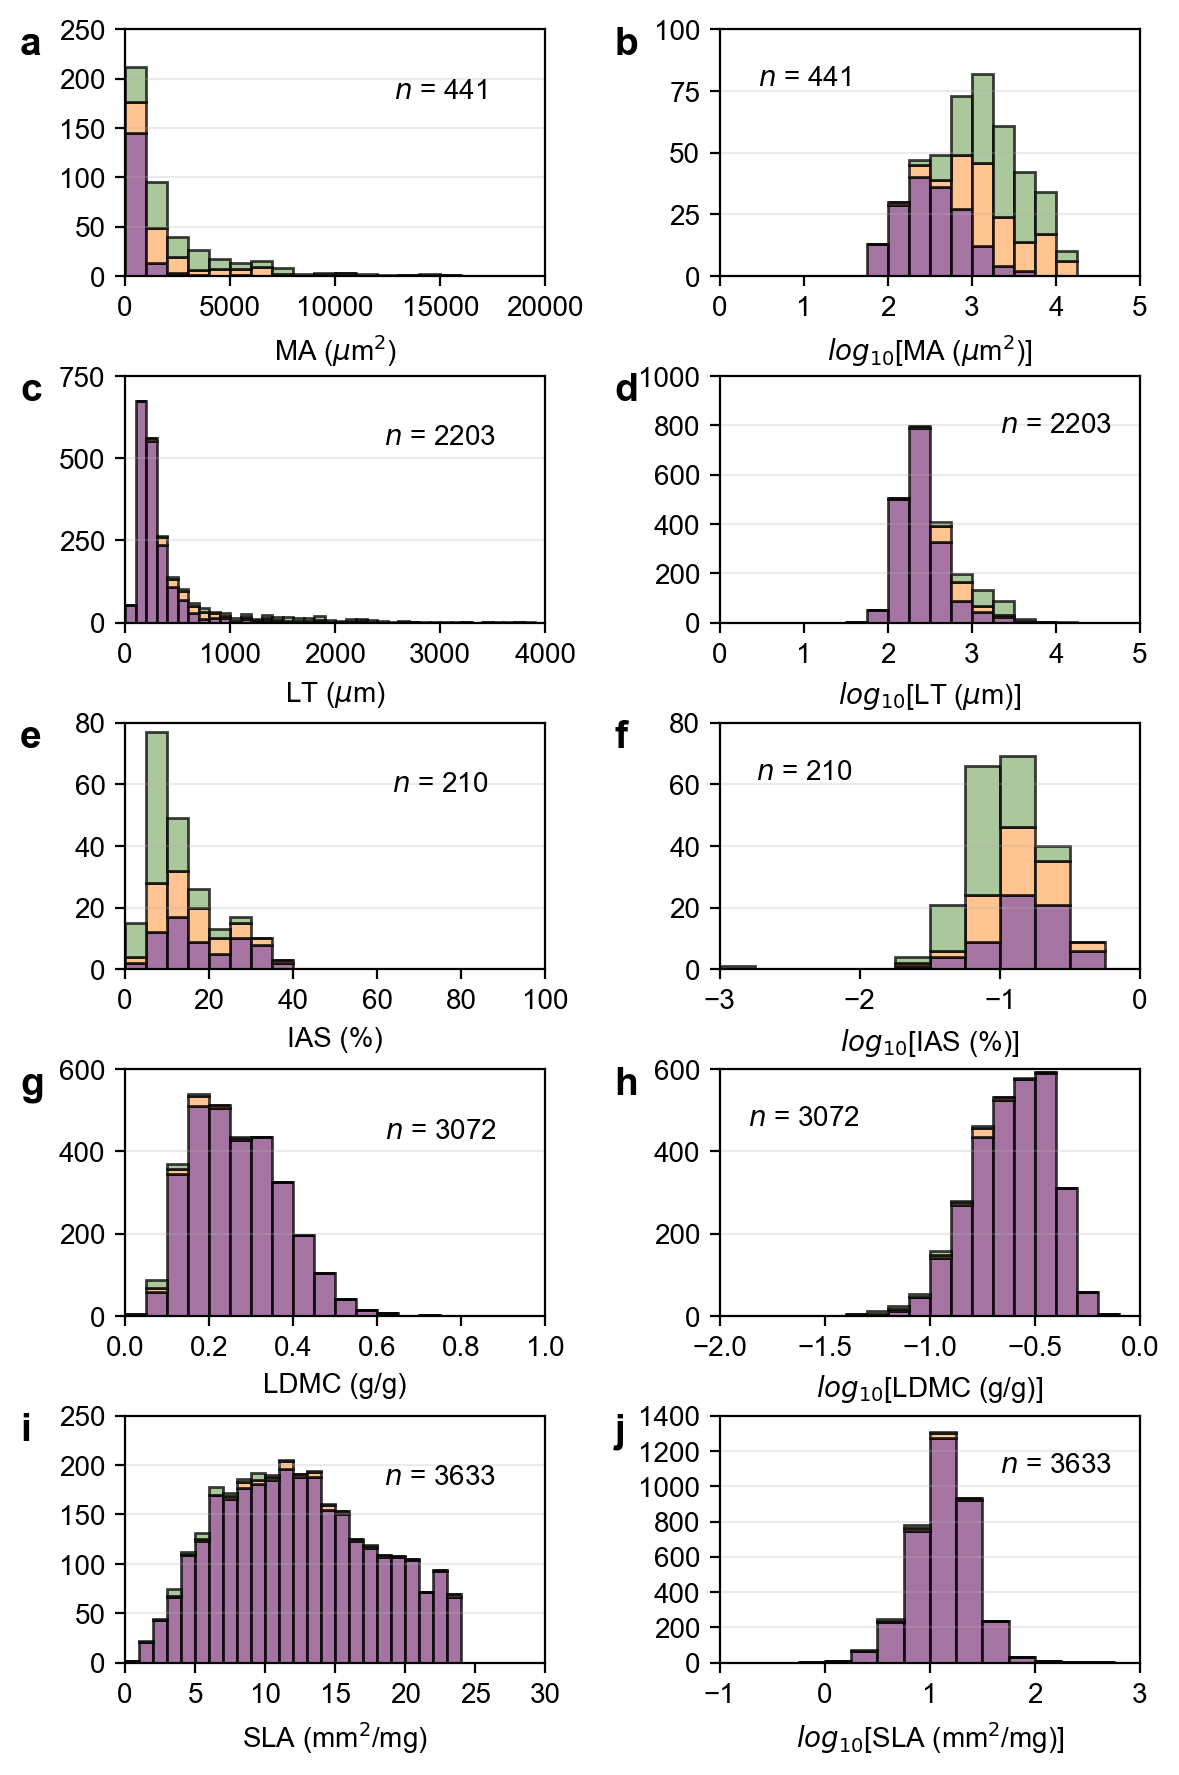

In [13]:
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(6,9))

bins = [np.arange(0, 5,0.25), 
        np.arange(0,5,0.25),
        np.arange(-3,3,0.25), 
        np.arange(-2,0,0.1),
        np.arange(-1,3,0.25)]
xlabs = [r'$log_{10}$[MA ($\mu$m$^2$)]', 
         r'$log_{10}$[LT ($\mu$m)]',
         r'$log_{10}$[IAS (%)]', 
         r'$log_{10}$[LDMC (g/g)]',         
         r'$log_{10}$[SLA (mm$^2$/mg)]']
ylabs = [r'stdev $log_{10}$[MA]', 
         r'stdev $log_{10}$[LT]',
         r'stdev $log_{10}$[IAS]',
         r'stdev $log_{10}$[LDMC]',         
         r'stdev $log_{10}$[SLA]']

rawDataCols = [c for c in morpho.columns if "mean" in c]
rawbins = [np.arange(0,20000,1000), np.arange(0,5000,100),
        np.arange(0,1,0.05), np.arange(0,1,0.05),
        np.arange(0,25,1), np.arange(0,10,0.5)]
rawxlabs = [r'MA ($\mu$m$^2$)', r'LT ($\mu$m)',
         r'IAS (%)', r'LDMC (g/g)',         
         r'SLA (mm$^2$/mg)']

for i,c in enumerate(rawDataCols):
    for j,p in enumerate(['non-CAM', 'mCAM', 'pCAM']):
        if j==0:
            hist = axes[i,0].hist(morpho[morpho["CAMpheno"]==p][c], bins=rawbins[i], color=camColorDict[p], edgecolor='black', alpha=0.75)
            bottom = hist[0]
        else:
            hist = axes[i,0].hist(morpho[morpho["CAMpheno"]==p][c], bins=rawbins[i], color=camColorDict[p], edgecolor='black', bottom=bottom, alpha=0.75)
            bottom = bottom+hist[0]
    axes[i,0].set_xlabel(rawxlabs[i])
    axes[i,0].text(0.75, 0.75, r"$n$ = {}".format(len(morpho[c].dropna())), horizontalalignment='center', verticalalignment='center', transform = axes[i,0].transAxes)

for i,c in enumerate(dataCols):
    for j,p in enumerate(['non-CAM', 'mCAM', 'pCAM']):
        if j==0:
            hist = axes[i,1].hist(logMorpho[logMorpho["CAMpheno"]==p][c], bins=bins[i], color=camColorDict[p], edgecolor='black', alpha=0.75)
            bottom = hist[0]
        else:
            hist = axes[i,1].hist(logMorpho[logMorpho["CAMpheno"]==p][c], bins=bins[i], color=camColorDict[p], edgecolor='black', bottom=bottom, alpha=0.75)
            bottom = bottom+hist[0]
            
    axes[i,1].set_xlabel(xlabs[i],size=10)
    if i in [0,2,3]:
        axes[i,1].text(0.2, 0.80, r"$n$ = {}".format(len(logMorpho[c].dropna())), horizontalalignment='center', verticalalignment='center', transform = axes[i,1].transAxes)
    else:
        axes[i,1].text(0.80, 0.80, r"$n$ = {}".format(len(logMorpho[c].dropna())), horizontalalignment='center', verticalalignment='center', transform = axes[i,1].transAxes)

axes[0,0].set_xlim(0,20000)
axes[1,0].set_xlim(0,4000)
axes[2,0].set_xlim(0,1)
axes[3,0].set_xlim(0,1)
axes[4,0].set_xlim(0,25)

axes[0,0].set_ylim(0,250)
axes[1,0].set_ylim(0,750)
axes[2,0].set_ylim(0,75)
axes[3,0].set_ylim(0,600)
axes[4,0].set_ylim(0,250)

axes[2,0].set_xticks(np.arange(0,1.1,0.2))
axes[2,0].set_xticklabels(np.arange(0,120,20))
axes[4,0].set_xticks(range(0,35,5))

axes[0,0].set_yticks(np.arange(0,300,50))
axes[1,0].set_yticks(np.arange(0,1000,250))
axes[2,0].set_yticks(np.arange(0,100,20))   
axes[4,0].set_yticks(np.arange(0,300,50))

axes[0,1].set_xticks(range(0,6,1))
axes[1,1].set_xticks(range(0,6,1))
axes[2,1].set_xticks(range(-3,4,1))
axes[0,1].set_xlim(0,5)
axes[1,1].set_xlim(0,5)
axes[2,1].set_xlim(-3,0)
axes[3,1].set_xlim(-2,0)
axes[4,1].set_xlim(-1,3)

axes[1,1].set_yticks(np.arange(0,1200,200))
axes[4,1].set_yticks(np.arange(0,1600,200))

axes[0,1].set_ylim(0,100)
axes[1,1].set_ylim(0,1000)
axes[2,0].set_ylim(0,80)
axes[2,1].set_ylim(0,80)
axes[3,1].set_ylim(0,600)
axes[4,1].set_ylim(0,1400)

for i,ax in enumerate(axes.flatten()):
    ax.grid(alpha=0.25, axis="y", which="both")
    ax.text(-0.25, 0.9, string.ascii_lowercase[i], transform = ax.transAxes, size=14, weight="bold")

plt.tight_layout(h_pad=-0.25)
# plt.savefig("../Figures/Colored-Raw-Transformed-Data.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

Now I'll plot the histograms broken into each class

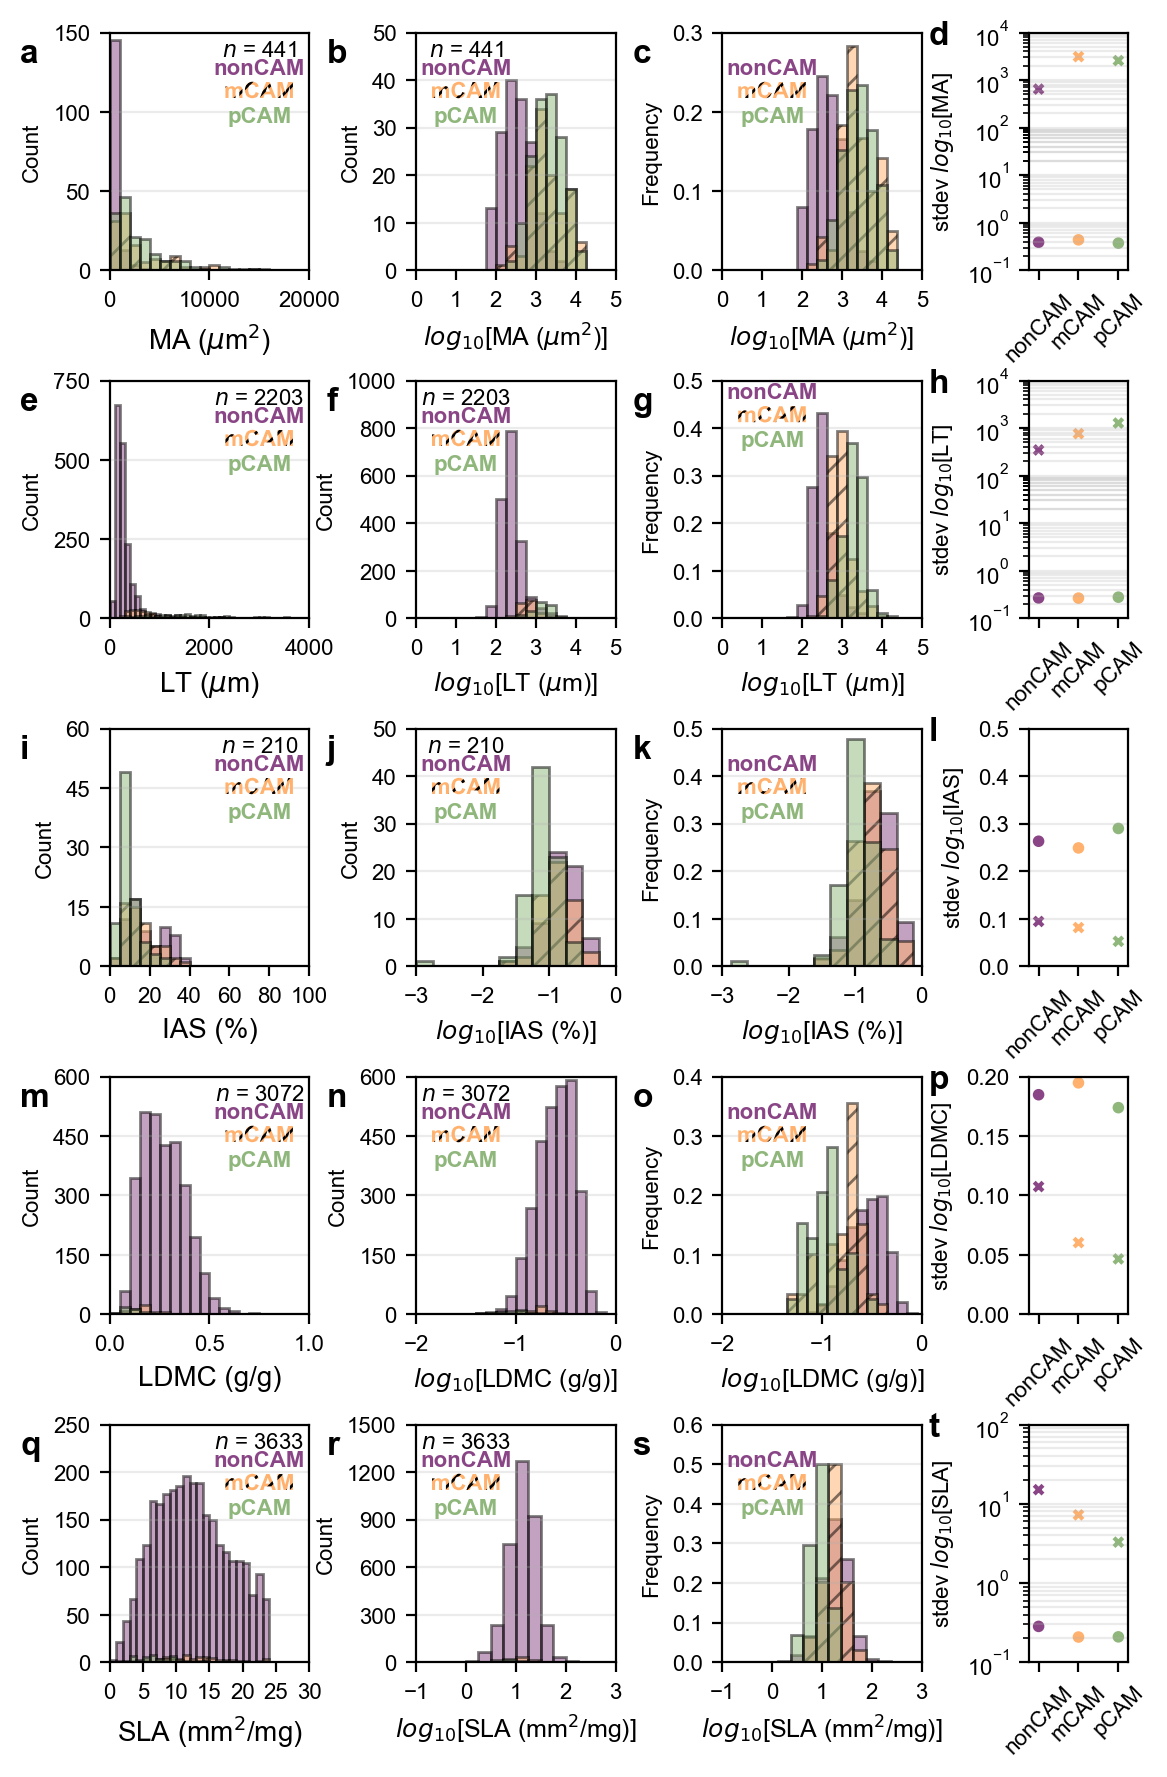

In [14]:
fig,axes = plt.subplots(nrows=5,ncols=4,figsize=(6,9), gridspec_kw={'width_ratios': [2,2,2,1]})

bins = [np.arange(0, 5,0.25), 
        np.arange(0,5,0.25),
        np.arange(-3,3,0.25), 
        np.arange(-2,0,0.1),
        np.arange(-1,3,0.25)]
xlabs = [r'$log_{10}$[MA ($\mu$m$^2$)]', 
         r'$log_{10}$[LT ($\mu$m)]',
         r'$log_{10}$[IAS (%)]', 
         r'$log_{10}$[LDMC (g/g)]',         
         r'$log_{10}$[SLA (mm$^2$/mg)]']
ylabs = [r'stdev $log_{10}$[MA]', 
         r'stdev $log_{10}$[LT]',
         r'stdev $log_{10}$[IAS]',
         r'stdev $log_{10}$[LDMC]',         
         r'stdev $log_{10}$[SLA]']

rawDataCols = [c for c in morpho.columns if "mean" in c]
rawbins = [np.arange(0,20000,1000), np.arange(0,5000,100),
        np.arange(0,1,0.05), np.arange(0,1,0.05),
        np.arange(0,25,1), np.arange(0,10,0.5)]
rawxlabs = [r'MA ($\mu$m$^2$)', r'LT ($\mu$m)',
         r'IAS (%)', r'LDMC (g/g)',         
         r'SLA (mm$^2$/mg)']

for i,rc in enumerate(rawDataCols):
    c=dataCols[i]
    for j,p in enumerate(['non-CAM', 'mCAM', 'pCAM']):
        if p=='mCAM':
            hatch="//"
        else:
            hatch=None
        
        axes[i,0].hist(morpho[morpho["CAMpheno"]==p][rc], bins=rawbins[i], color=camColorDict[p], edgecolor='black', alpha=0.5, hatch=hatch)
        
        hist = axes[i,1].hist(logMorpho[logMorpho["CAMpheno"]==p][c], bins=bins[i], color=camColorDict[p], edgecolor='black', alpha=0.5, hatch=hatch)
        normed = hist[0]/sum(hist[0])
        axes[i,2].bar(x=bins[i][:-1]+bins[i][1]-bins[i][0], height=normed, color=camColorDict[p], edgecolor='black', alpha=0.5, width=bins[i][1]-bins[i][0], hatch=hatch)

    axes[i,0].set_xlabel(rawxlabs[i])
    axes[i,0].text(0.75, 0.925, r"$n$ = {}".format(len(morpho[c].dropna())), horizontalalignment='center', verticalalignment='center', transform = axes[i,0].transAxes, size=8)
        
    axes[i,1].set_xlabel(xlabs[i],size=9)
    axes[i,2].set_xlabel(xlabs[i],size=9)  
    axes[i,1].text(0.25, 0.925, r"$n$ = {}".format(len(logMorpho[c].dropna())), horizontalalignment='center', verticalalignment='center', transform = axes[i,1].transAxes, size=8)

for i,c in enumerate(dataCols):
    axes[i,3].scatter(x=[0,1,2], y=list(morpho.groupby("CAMpheno").describe()[c]["std"][[1,0,2]]), marker="x", s=10, color=[nonCAMcolor,nonpCAMcolor,pCAMcolor])
    axes[i,3].scatter(x=[0,1,2], y=list(logMorpho.groupby("CAMpheno").describe()[c]["std"][[1,0,2]]), marker="o", s=10, color=[nonCAMcolor,nonpCAMcolor,pCAMcolor])
    axes[i,3].set_xticks([0,1,2])
    axes[i,3].set_xticklabels(["nonCAM", "mCAM", "pCAM"],size=8,rotation=45)
    axes[i,3].set_xlim([-0.25,2.25]) 
    axes[i,3].set_ylabel(ylabs[i],size=8)
    
axes[0,0].set_xlim(0,20000)
axes[1,0].set_xlim(0,4000)
axes[2,0].set_xlim(0,1)
axes[3,0].set_xlim(0,1)
axes[4,0].set_xlim(0,25)

axes[2,0].set_xticks(np.arange(0,1.1,0.2))
axes[4,0].set_xticks(range(0,35,5))
axes[4,1].set_xticks(range(-1,4))
axes[4,2].set_xticks(range(-1,4))
axes[2,0].set_xticklabels(np.arange(0,120,20), size=9)

for i in [1,2]:
    axes[0,i].set_xticks(range(0,6,1))
    axes[1,i].set_xticks(range(0,6,1))
    axes[2,i].set_xticks(range(-3,4,1))
    axes[0,i].set_xlim(0,5)
    axes[1,i].set_xlim(0,5)
    axes[2,i].set_xlim(-3,0)
    axes[3,i].set_xlim(-2,0)
    axes[4,i].set_xlim(-1,3)

axes[0,0].set_yticks(np.arange(0,300,50))
axes[1,0].set_yticks(np.arange(0,1000,250))
axes[2,0].set_yticks(np.arange(0,150,15))  
axes[3,0].set_yticks(np.arange(0,1500,150))
axes[4,0].set_yticks(np.arange(0,300,50))
axes[0,1].set_yticks(np.arange(0,100,10))
axes[1,1].set_yticks(np.arange(0,1200,200))
axes[2,1].set_yticks(np.arange(0,60,10))  
axes[3,1].set_yticks(np.arange(0,1500,150))
axes[4,1].set_yticks(np.arange(0,1800,300))
axes[0,2].set_yticks(np.arange(0,1,0.1))
axes[1,2].set_yticks(np.arange(0,1,0.1))
axes[2,2].set_yticks(np.arange(0,1,0.1))  
axes[3,2].set_yticks(np.arange(0,1,0.1))
axes[4,2].set_yticks(np.arange(0,1,0.1))

axes[0,0].set_ylim(0,150)
axes[1,0].set_ylim(0,750)
axes[2,0].set_ylim(0,60)
axes[3,0].set_ylim(0,600)
axes[4,0].set_ylim(0,250)
axes[0,1].set_ylim(0,50)
axes[1,1].set_ylim(0,1000)
axes[2,1].set_ylim(0,50)
axes[3,1].set_ylim(0,600)
axes[4,1].set_ylim(0,1500)
axes[0,2].set_ylim(0,0.3)
axes[1,2].set_ylim(0,0.5)
axes[2,2].set_ylim(0,0.5)
axes[3,2].set_ylim(0,0.4)
axes[4,2].set_ylim(0,0.6)

axes[0,3].semilogy()
axes[1,3].semilogy()
axes[4,3].semilogy()

axes[0,3].set_yticks([0.1,1,10,100,1000,10000])
axes[0,3].set_yticks(np.concatenate([np.arange(0.0,1.1,0.1)*m for m in [1,10,100,100,1000, 10000]]), minor=True)
axes[1,3].set_yticks([0.1,1,10,100,1000,10000])
axes[1,3].set_yticks(np.concatenate([np.arange(0.0,1.1,0.1)*m for m in [1,10,100,100,1000, 10000]]), minor=True)

axes[0,3].set_ylim(0.1,10000)
axes[1,3].set_ylim(0.1,10000)
axes[2,3].set_ylim(0,0.5)
axes[3,3].set_ylim(0,0.2)
axes[4,3].set_ylim(0.1,100)

for i,ax in enumerate(axes.flatten()):
    ax.grid(alpha=0.25, axis="y", which="both")
    ax.tick_params(axis='both', which='major', labelsize=8)

    x=0.25
    y0=0.85
    if i in [6,22]:
        y0=0.95
    if i%4 ==3:
        ax.text(-1.0, 0.95, string.ascii_lowercase[i], transform = ax.transAxes, size=12, weight="bold")
    else:
        if i%4 == 2:
            ax.set_ylabel("Frequency", size=8)
        else:
            ax.set_ylabel("Count", size=8)
            if i%4==0:
                x=0.75            

        ax.text(x, y0, r"nonCAM", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, size=8, color=camColorDict["non-CAM"], weight='bold')
        t = ax.text(x, y0-0.1, r"mCAM", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, size=8, color=camColorDict["mCAM"], weight='bold')
        t.set_path_effects([path_effects.Stroke(hatch='///',)])
        ax.text(x, y0-0.2, r"pCAM", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, size=8,color=camColorDict["pCAM"], weight='bold')
        ax.text(-0.45, 0.875, string.ascii_lowercase[i], transform = ax.transAxes, size=12, weight="bold")
    
plt.tight_layout(w_pad=-1., h_pad=0)
# plt.savefig("../Figures/Colored-Raw-Transformed-Histograms.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

We can now use the Kruskal-Wallis (KW) test to test for group differences.

In [15]:
for c in dataCols:
    print(c)
    print(stats.kruskal(logMorpho[logMorpho["CAMpheno"]=="non-CAM"][c].dropna(),
              logMorpho[logMorpho["CAMpheno"]=="mCAM"][c].dropna(),
              logMorpho[logMorpho["CAMpheno"]=="pCAM"][c].dropna()))
    print()

MAmean (um^2)
KruskalResult(statistic=208.90269300234533, pvalue=4.3386696833635185e-46)

LTmean (um)
KruskalResult(statistic=714.989067495795, pvalue=5.522003565366916e-156)

IASmean (%)
KruskalResult(statistic=44.09769434407337, pvalue=2.6564848340712795e-10)

LDMCmean (g/g)
KruskalResult(statistic=151.73417683467665, pvalue=1.125491300031785e-33)

dSLAmean (mm^2/mg)
KruskalResult(statistic=57.25758363138526, pvalue=3.6870046971597167e-13)



All tests rejected the null hypothesis, and therefore found significant group differences.

In [16]:
dunnMA = skph.posthoc_dunn(logMorpho[~logMorpho["MAmean (um^2)"].isna()], val_col="MAmean (um^2)", group_col="CAMpheno", p_adjust="fdr_bh", sort=True)
dunnLT = skph.posthoc_dunn(logMorpho[~logMorpho["LTmean (um)"].isna()], val_col="LTmean (um)", group_col="CAMpheno", p_adjust="fdr_bh", sort=True)
dunnIAS = skph.posthoc_dunn(logMorpho[~logMorpho["IASmean (%)"].isna()], val_col="IASmean (%)", group_col="CAMpheno", p_adjust="fdr_bh", sort=True)
dunnLDMC = skph.posthoc_dunn(logMorpho[~logMorpho["LDMCmean (g/g)"].isna()], val_col="LDMCmean (g/g)", group_col="CAMpheno", p_adjust="fdr_bh", sort=True)
dunnSLA = skph.posthoc_dunn(logMorpho[~logMorpho["dSLAmean (mm^2/mg)"].isna()], val_col="dSLAmean (mm^2/mg)", group_col="CAMpheno", p_adjust="fdr_bh", sort=True)
dunnResults = [dunnMA,dunnLT,dunnIAS,dunnLDMC,dunnSLA]

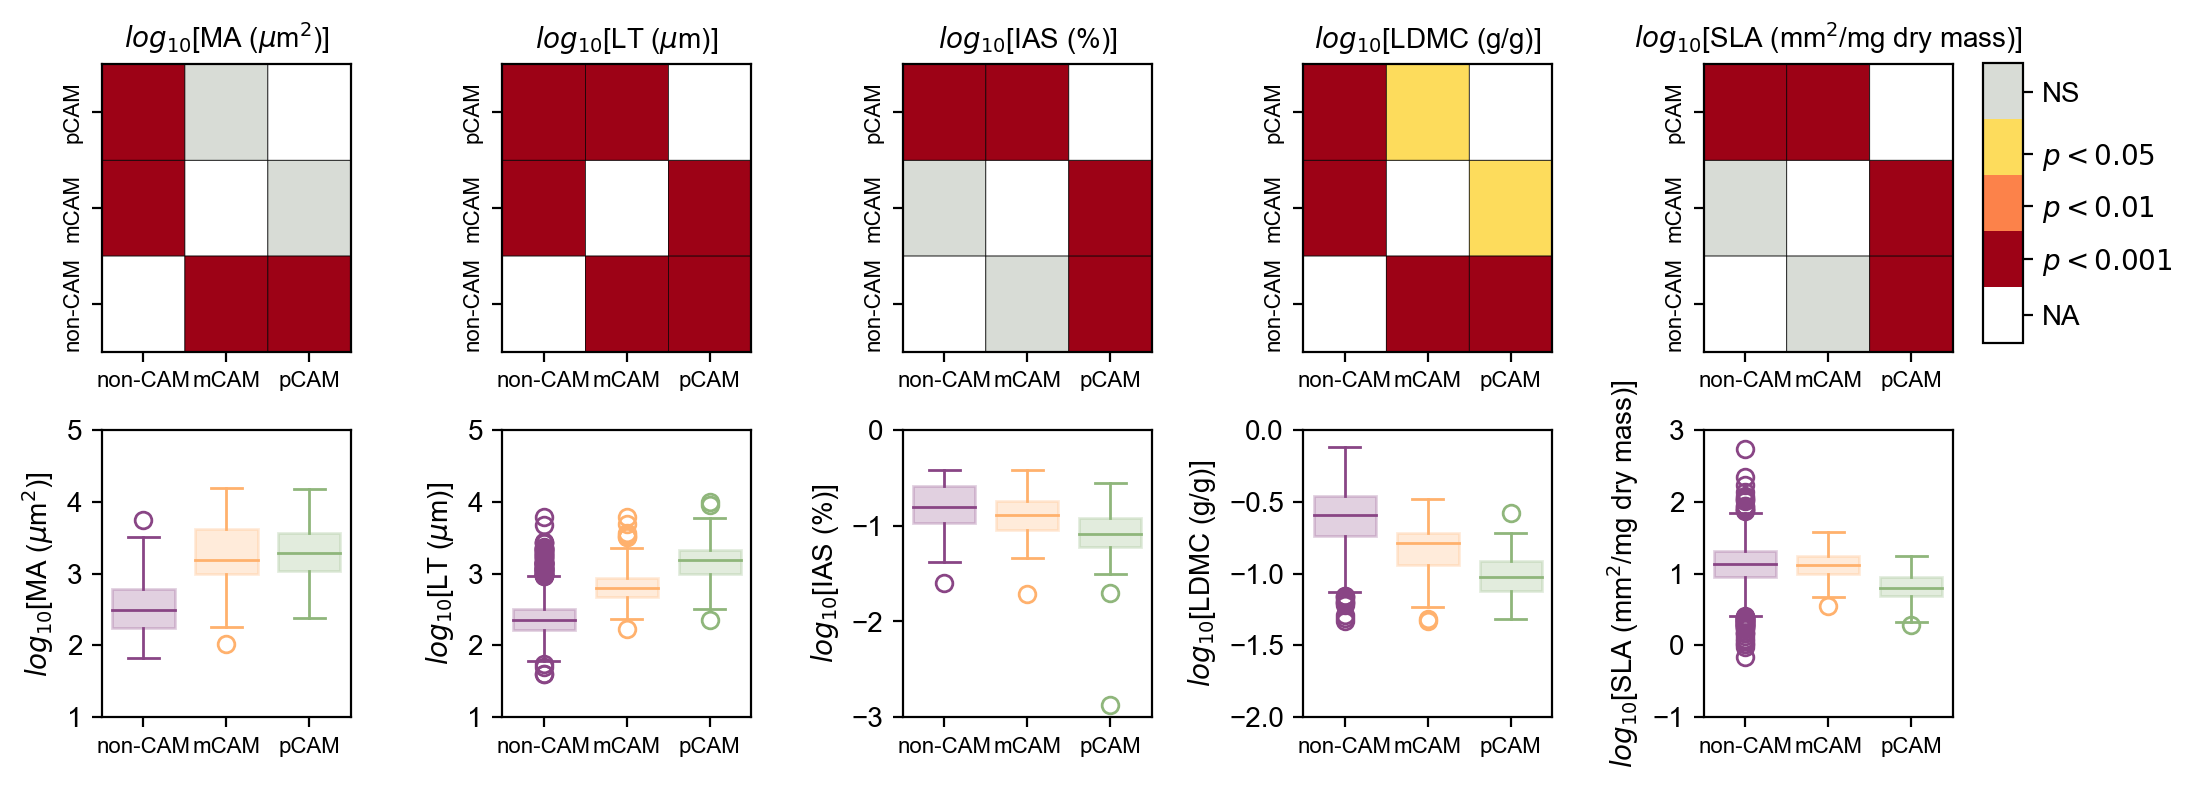

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=5, figsize=(10,4))

ylabs = [r'$log_{10}$[MA ($\mu$m$^2$)]', 
         r'$log_{10}$[LT ($\mu$m)]',
         r'$log_{10}$[IAS (%)]', 
         r'$log_{10}$[LDMC (g/g)]',         
         r'$log_{10}$[SLA (mm$^2$/mg dry mass)]']

sigColors = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
sigCmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', sigColors, N=5)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = mcolors.BoundaryNorm(bounds, sigCmap.N)

pmapMA = axes[0,0].pcolor(dunnMA.loc[["non-CAM","mCAM","pCAM"]][["non-CAM","mCAM","pCAM"]], cmap=sigCmap, norm=norm, edgecolors="black")
pmapLT = axes[0,1].pcolor(dunnLT.loc[["non-CAM","mCAM","pCAM"]][["non-CAM","mCAM","pCAM"]], cmap=sigCmap, norm=norm, edgecolors="black")
pmapIAS = axes[0,2].pcolor(dunnIAS.loc[["non-CAM","mCAM","pCAM"]][["non-CAM","mCAM","pCAM"]], cmap=sigCmap, norm=norm, edgecolors="black")
pmapLDMA = axes[0,3].pcolor(dunnLDMC.loc[["non-CAM","mCAM","pCAM"]][["non-CAM","mCAM","pCAM"]], cmap=sigCmap, norm=norm, edgecolors="black")
pmapSLA = axes[0,4].pcolor(dunnSLA.loc[["non-CAM","mCAM","pCAM"]][["non-CAM","mCAM","pCAM"]], cmap=sigCmap, norm=norm, edgecolors="black")

cax = fig.add_axes([axes[0,-1].get_position().x1+0.1, axes[0,-1].get_position().y0+0.025, 0.02, axes[0,-1].get_position().height])
cbar = plt.colorbar(pmapSLA, cax=cax, cmap=sigCmap, norm=norm, boundaries=bounds, ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for j,c in enumerate(dataCols):
    for i,p in enumerate(["non-CAM", "mCAM", "pCAM"]):
        axes[1,j].boxplot(x=logMorpho[logMorpho["CAMpheno"]==p][c].dropna(), positions=[i], widths=[0.75], bootstrap=10000, 
                             patch_artist=True, boxprops=dict(facecolor=camColorDict[p], color=camColorDict[p], alpha=0.25), capprops=dict(color=camColorDict[p]), 
                             whiskerprops=dict(color=camColorDict[p]), flierprops=dict(color=camColorDict[p], markeredgecolor=camColorDict[p]), medianprops=dict(color=camColorDict[p]))
    
    axes[1,j].set_xticks([0,1,2])
    axes[1,j].set_xticklabels(["non-CAM", "mCAM", "pCAM"], size=8)
    axes[1,j].set_ylabel(ylabs[j])
    
    axes[0,j].set_title(ylabs[j], size=10)
    axes[0,j].set_xticks([0.5,1.5,2.5])
    axes[0,j].set_yticks([0.5,1.5,2.5])
    axes[0,j].set_xticklabels(["non-CAM", "mCAM", "pCAM"], size=8)
    axes[0,j].set_yticklabels(["non-CAM", "mCAM", "pCAM"], rotation=90, size=8, va="center")

axes[1,0].set_ylim(1,5)
axes[1,1].set_ylim(1,5)
axes[1,2].set_ylim(-3,0)
axes[1,3].set_ylim(-2,0)
axes[1,4].set_ylim(-1,3)

plt.tight_layout()

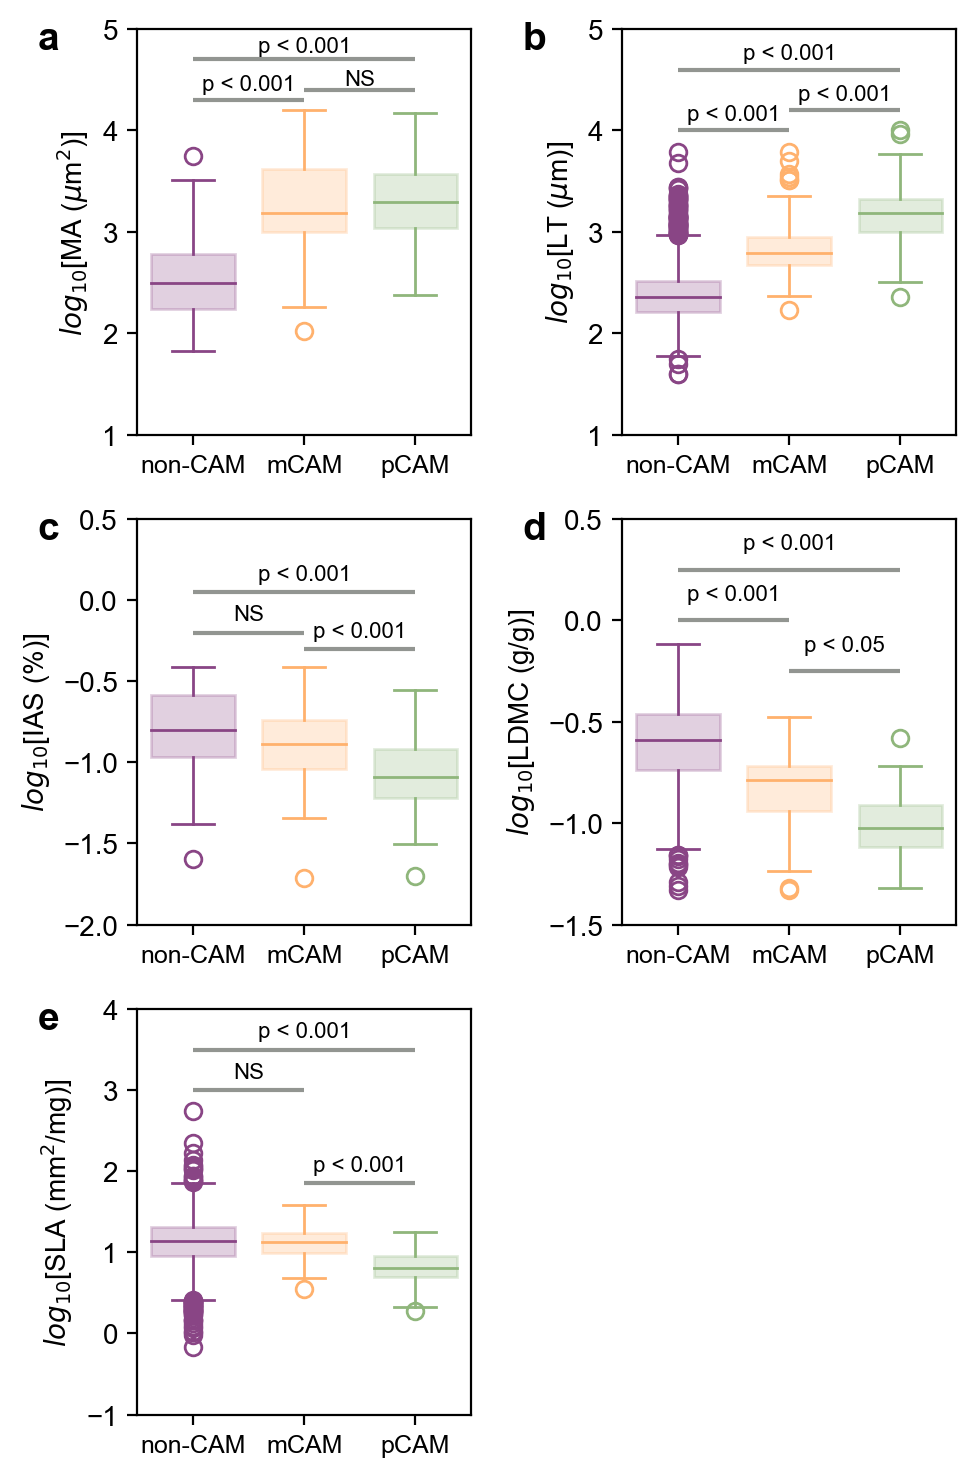

In [18]:
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(5,7.5))

ylabs = [r'$log_{10}$[MA ($\mu$m$^2$)]', 
         r'$log_{10}$[LT ($\mu$m)]',
         r'$log_{10}$[IAS (%)]', 
         r'$log_{10}$[LDMC (g/g)]',         
         r'$log_{10}$[SLA (mm$^2$/mg)]']

flatAxes = axes.flatten()
for ax,c in enumerate(dataCols):
    for i,p in enumerate(["non-CAM", "mCAM", "pCAM"]):
        boxplot = flatAxes[ax].boxplot(x=logMorpho[logMorpho["CAMpheno"]==p][c].dropna(), positions=[i], widths=[0.75], bootstrap=10000, 
                             patch_artist=True, boxprops=dict(facecolor=camColorDict[p], color=camColorDict[p], alpha=0.25), capprops=dict(color=camColorDict[p]), 
                             whiskerprops=dict(color=camColorDict[p]), flierprops=dict(color=camColorDict[p], markeredgecolor=camColorDict[p]), medianprops=dict(color=camColorDict[p]))
    
    flatAxes[ax].set_xticks([0,1,2])
    flatAxes[ax].set_xticklabels(["non-CAM", "mCAM", "pCAM"], size=9)
    flatAxes[ax].set_ylabel(ylabs[ax])

axes[0,0].hlines(y=4.4, xmin=1, xmax=2, color="xkcd:grey")
axes[0,0].text(s="NS", x=1.5, y=4.45, ha="center", size=8)
axes[0,0].hlines(y=4.3, xmin=0, xmax=1, color="xkcd:grey")
axes[0,0].text(s="p < 0.001", x=0.5, y=4.4, ha="center", size=8)
axes[0,0].hlines(y=4.7, xmin=0, xmax=2, color="xkcd:grey")
axes[0,0].text(s="p < 0.001", x=1, y=4.775, ha="center", size=8)

axes[0,1].hlines(y=4.2, xmin=1, xmax=2, color="xkcd:grey")
axes[0,1].text(s="p < 0.001", x=1.5, y=4.3, ha="center", size=8)
axes[0,1].hlines(y=4.0, xmin=0, xmax=1, color="xkcd:grey")
axes[0,1].text(s="p < 0.001", x=0.5, y=4.1, ha="center", size=8)
axes[0,1].hlines(y=4.6, xmin=0, xmax=2, color="xkcd:grey")
axes[0,1].text(s="p < 0.001", x=1, y=4.7, ha="center", size=8)

axes[1,0].hlines(y=-0.3, xmin=1, xmax=2, color="xkcd:grey")
axes[1,0].text(s="p < 0.001", x=1.5, y=-0.225, ha="center", size=8)
axes[1,0].hlines(y=-0.2, xmin=0, xmax=1, color="xkcd:grey")
axes[1,0].text(s="NS", x=0.5, y=-0.125, ha="center", size=8)
axes[1,0].hlines(y=0.05, xmin=0, xmax=2, color="xkcd:grey")
axes[1,0].text(s="p < 0.001", x=1, y=0.125, ha="center", size=8)

axes[1,1].hlines(y=-0.25, xmin=1, xmax=2, color="xkcd:grey")
axes[1,1].text(s="p < 0.05", x=1.5, y=-0.15, ha="center", size=8)
axes[1,1].hlines(y=0, xmin=0, xmax=1, color="xkcd:grey")
axes[1,1].text(s="p < 0.001", x=0.5, y=0.1, ha="center", size=8)
axes[1,1].hlines(y=0.25, xmin=0, xmax=2, color="xkcd:grey")
axes[1,1].text(s="p < 0.001", x=1, y=0.35, ha="center", size=8)

axes[2,0].hlines(y=1.85, xmin=1, xmax=2, color="xkcd:grey")
axes[2,0].text(s="p < 0.001", x=1.5, y=2, ha="center", size=8)
axes[2,0].hlines(y=3, xmin=0, xmax=1, color="xkcd:grey")
axes[2,0].text(s="NS", x=0.5, y=3.15, ha="center", size=8)
axes[2,0].hlines(y=3.5, xmin=0, xmax=2, color="xkcd:grey")
axes[2,0].text(s="p < 0.001", x=1, y=3.65, ha="center", size=8)

    
axes[0,0].set_ylim(1,5)
axes[0,1].set_ylim(1,5)
axes[1,0].set_ylim(-2,0.5)
axes[1,1].set_ylim(-1.5,0.5)
axes[2,0].set_ylim(-1,4)

for (ax,s) in zip(axes.flatten()[:-1],'abcde'):
    ax.text(s=s, x=-0.3, y=0.95, size=14, transform = ax.transAxes, weight="bold")

flatAxes[-1].axis('off')
plt.tight_layout()
# plt.savefig("../Figures/GroupDifferenceBoxPlots.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

We can draw a few conclusions from these results:
- Non-CAM and primary CAM plants significantly differ across all variables in expected ways: they have larger mesophyll cells, thicker leaves, less intercellular air space (IAS), lower leaf dry matter content (LDMC), and lower specific leaf area (SLA).
- Minority CAM species are somewhat intermediate.
    - There was no difference between mesophyll cell size of primary and minority CAM species.
    - There were no significant differences in SLA and IAS of non-CAM and mCAM species. 

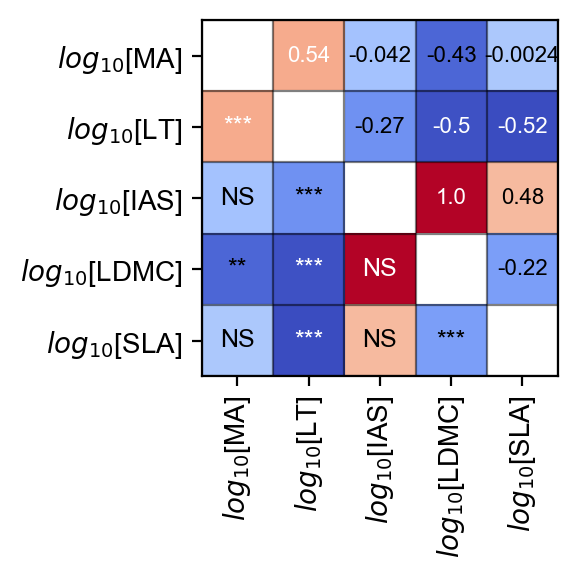

In [19]:
fig,ax = plt.subplots(figsize=(3,3))

corr = logMorpho[dataCols].corr().values
for i in range(len(corr)):
    corr[i,i] = np.nan
    
corrPlot = ax.imshow(corr, cmap="coolwarm",)

ax.set_xticks(np.arange(-0.5,5.5,1), minor=True)
ax.set_yticks(np.arange(-0.5,5.5,1), minor=True)
ax.set_xticks(np.arange(0,5,1))
ax.set_yticks(np.arange(0,5,1))
ax.set_xticklabels([r'$log_{10}$[MA]', r'$log_{10}$[LT]', r'$log_{10}$[IAS]',r'$log_{10}$[LDMC]', r'$log_{10}$[SLA]'], rotation=90)
ax.set_yticklabels([r'$log_{10}$[MA]', r'$log_{10}$[LT]', r'$log_{10}$[IAS]',r'$log_{10}$[LDMC]', r'$log_{10}$[SLA]'])

for i,x in enumerate(dataCols):
    for j,y in enumerate(dataCols):
        if i==j:
            continue
        else:
            df = logMorpho[[x,y]].dropna()
            try:
                r,p = stats.pearsonr(df[x],df[y])
                if p < 0.001: s = "***"
                elif p < 0.01: s = "**"
                elif p < 0.05: s = "*"
                else: s = "NS"
                    
                if abs(r)>0.5: c="white"
                else: c="black"
            except:
                s = "NA"
                r = "NA"
                c="black"
            
            if j>i:
                ax.text(x=i,y=j,s=s, ha="center", va="center", color=c, size=9)
            else:
                try:
                    ax.text(x=i,y=j,s="{:0.2}".format(r), ha="center", va="center", color=c, size=8)
                except:
                    ax.text(x=i,y=j,s=r, ha="center", va="center", color=c, size=8)
            del r,s
            

ax.tick_params(which="minor", size=0)
ax.grid(which="minor", color="black", alpha=0.5)

plt.tight_layout()
# plt.savefig("../Figures/FeatureCorrelationMatrix.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

### A few extra plots and tests

In [20]:
aspar = logMorpho[logMorpho["MajorLineage"].isin(["Agavoideae","Nolinoideae","Asparagaceae"])]
orchids = logMorpho[logMorpho["MajorLineage"]=="Orchidaceae"]
broms = logMorpho[logMorpho["MajorLineage"]=="Bromeliaceae"]
portullugoFams = ["Anacampserotaceae", "Basellaceae", "Cactaceae", "Didiereaceae","Halophytaceae","Molluginaceae","Montiaceae","Talinaceae"]
portullugo = logMorpho[logMorpho["MajorLineage"].isin(portullugoFams)]

In [21]:
def sigText(f):
    if f < 0.001: return "***"
    elif f < 0.01: return "**"
    elif f < 0.05: return ("*")
    else: return "NS"

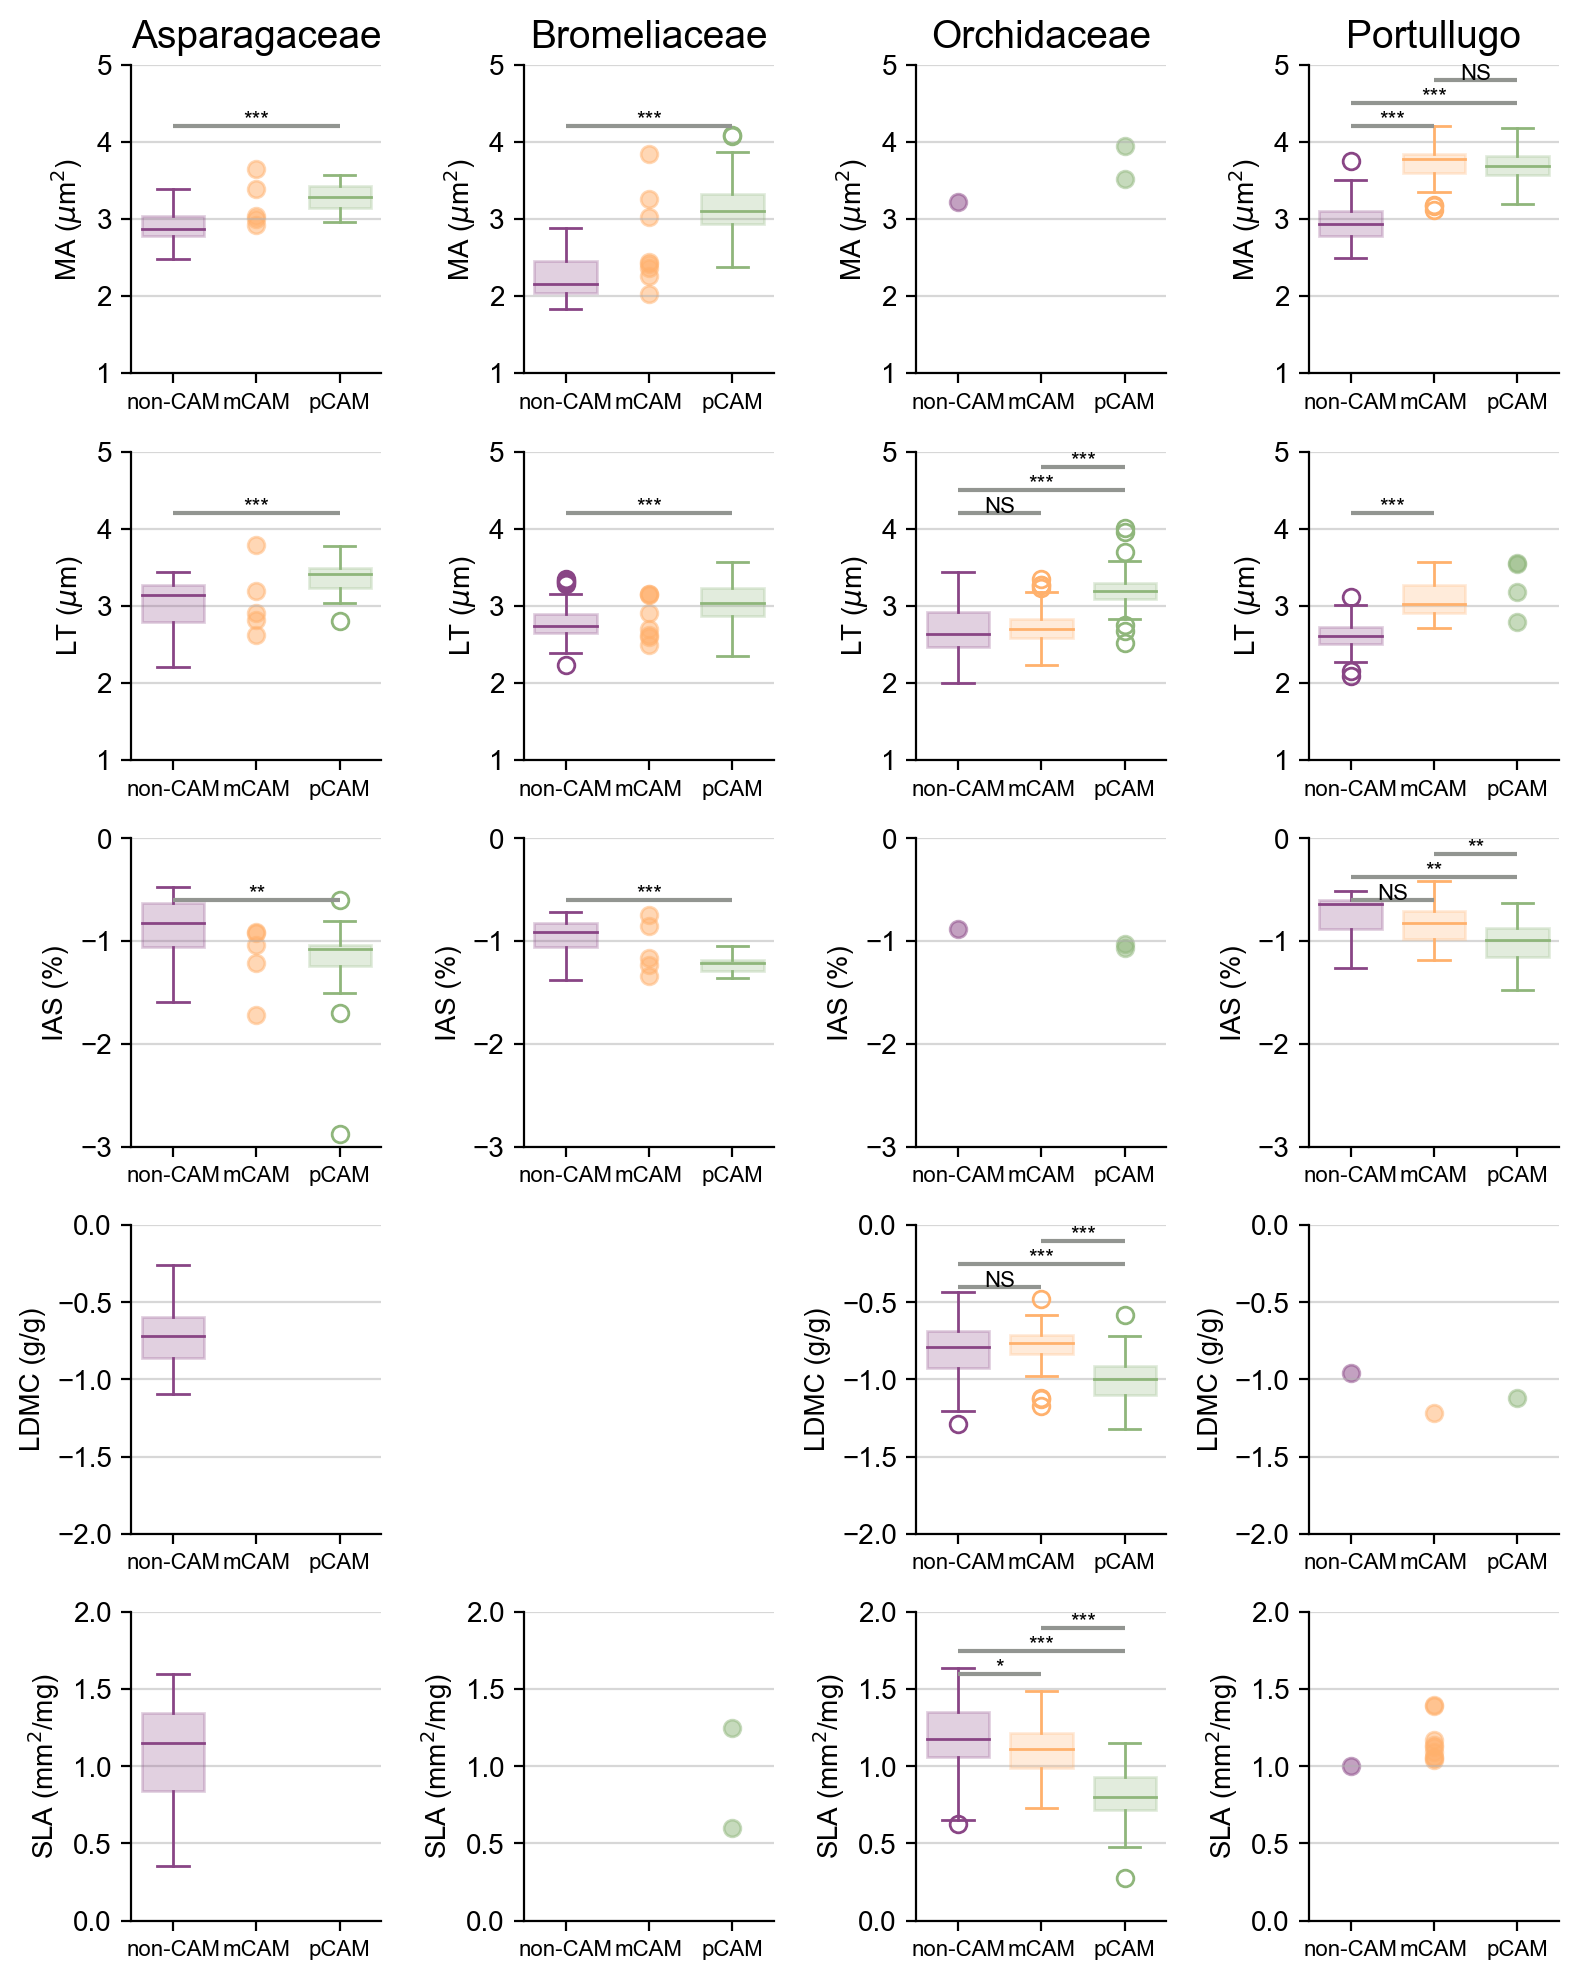

In [22]:
fig, axes = plt.subplots(nrows=5,ncols=4, figsize=(8,8*(5/4)))

ylabs = [r'MA ($\mu$m$^2$)', 
         r'LT ($\mu$m)',
         r'IAS (%)', 
         r'LDMC (g/g)',         
         r'SLA (mm$^2$/mg)']*3

plotN = 0
for j,c in enumerate(dataCols):
    for i,df in enumerate([aspar, broms, orchids, portullugo]):
        plotN += 1
        if len(df[~df[c].isna()]) > 0:
            traitDict = dict()
            for k,p in enumerate(["non-CAM", "mCAM", "pCAM"]):
                if len(df[(df["CAMpheno"]==p) & (~df[c].isna())]) > 10:
                    traitDict[k] = list(df[df["CAMpheno"]==p][c].dropna())
                    
                    axes[j,i].boxplot(x=df[df["CAMpheno"]==p][c].dropna(), positions=[k], widths=[0.75], bootstrap=10000, 
                                         patch_artist=True, boxprops=dict(facecolor=camColorDict[p], color=camColorDict[p], alpha=0.25), capprops=dict(color=camColorDict[p]), 
                                         whiskerprops=dict(color=camColorDict[p]), flierprops=dict(color=camColorDict[p], markeredgecolor=camColorDict[p]), medianprops=dict(color=camColorDict[p]))
                    
                    df[df["CAMpheno"]==p][c].dropna()
                else:
                    axes[j,i].scatter(x=[k]*len(df[df["CAMpheno"]==p][c]), y=df[df["CAMpheno"]==p][c], color=camColorDict[p], alpha=0.5)
                axes[j,i].set_xticks([0,1,2])
                axes[j,i].set_xticklabels(["non-CAM", "mCAM", "pCAM"], size=8)
                axes[j,i].set_xlim(-0.5,2.5)
                axes[j,i].set_ylabel(ylabs[j])
                axes[j,i].spines['top'].set_visible(False)
                axes[j,i].spines['right'].set_visible(False)
            
            if len(sorted(traitDict)) > 1:
                kw,pval = eval("stats.kruskal({})".format(",".join(["traitDict[{}]".format(v) for v in sorted(traitDict)])))
                if pval < 0.05:
                    traitDF = pd.DataFrame(zip(flatten([traitDict[k] for k in sorted(traitDict)]),
                                               flatten([np.repeat(k, len(traitDict[k])) for k in sorted(traitDict)])), 
                                           columns=["trait","pheno"])
                    dunn = skph.posthoc_dunn(traitDF, group_col="pheno", val_col="trait", p_adjust="fdr_bh", sort=True)
                    
                    height = 0.8
                    step = 0.075
                    for row in dunn.index:
                        for col in dunn.index:
                            if row >= col: continue
                            else:
                                axes[j,i].hlines(y=height, xmin=row, xmax=col, color="xkcd:grey", transform=axes[j,i].get_xaxis_transform())
                                axes[j,i].text(s=sigText(dunn.loc[row][col]), x=np.mean([row,col]), y=height, ha="center", size=8, transform=axes[j,i].get_xaxis_transform())
                                height += step

        else:
            axes[j,i].axis('off')
            
        
        axes[0,i].set_yticks(np.arange(1,6,1))
        axes[0,i].set_ylim(1,5)
        axes[1,i].set_yticks(np.arange(1,6,1))
        axes[1,i].set_ylim(1,5)
        axes[2,i].set_ylim(-3,0)
        axes[3,i].set_ylim(-2,0)
        axes[4,i].set_ylim(0,2)
        
        axes[j,i].grid(alpha=0.5, axis="y")
        
axes[0,0].set_title("Asparagaceae", size=14)        
axes[0,1].set_title("Bromeliaceae", size=14)
axes[0,2].set_title("Orchidaceae", size=14)
axes[0,3].set_title("Portullugo", size=14)

plt.tight_layout()
# plt.savefig("../Figures/SelectCladeDifferences.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")

The little significance connection lines didn't turn out perfect, but that's easy enough to fix in Illustrator.

# Phylogenetic results
## PGLS

In [23]:
pglsRes = pd.read_csv("../Results/PGLS-results.csv")
pglsRes["color"] = ["xkcd:reddish" if t=="OU" else "xkcd:bluish" for t in pglsRes["TraitEvoModel"]]
pglsRes["ls"] = ["--" if t=="OU" else "-" for t in pglsRes["TraitEvoModel"]]
for t in ["IAS","MA","LT"]:
    pglsRes["PGLS_model"] = [re.sub(t, "log"+t, s) for s in pglsRes["PGLS_model"]]
pglsRes["PGLS_model"] = [re.sub("CAM phenotype", "CAMphenoCat", s) for s in pglsRes["PGLS_model"]]
pglsRes

,PGLS_model,AIC,TraitEvoModel,Intercept,Intercept_StdErr,Intercept_pval,Coef_1,Coef_1_StdErr,Coef_1_pval,DF,color,ls
0,logIAS ~ logMA,8.058725,BM,-1.818981,0.374851,0.0000,0.292175,0.101675,0.0061,49,xkcd:bluish,-
1,logIAS ~ logMA,3.815509,OU,-1.370625,0.349623,0.0003,0.153716,0.098032,0.1236,49,xkcd:reddish,--
2,logLT ~ logMA,8.357876,BM,1.523355,0.377163,0.0003,0.389871,0.105367,0.0007,39,xkcd:bluish,-
3,logLT ~ logMA,-5.061867,OU,1.130349,0.285665,0.0004,0.512749,0.080945,0.0000,39,xkcd:reddish,--
4,logLT ~ logIAS,22.563500,BM,2.914962,0.222108,0.0000,0.102799,0.200857,0.6122,35,xkcd:bluish,-
5,logLT ~ logIAS,20.690110,OU,3.024758,0.202115,0.0000,0.214940,0.206997,0.3066,35,xkcd:reddish,--
6,logMA ~ CAMphenoCat,76.525150,BM,3.185646,0.280736,0.0000,0.078443,0.113928,0.4935,68,xkcd:bluish,-
7,logMA ~ CAMphenoCat,44.359820,OU,3.128037,0.133491,0.0000,0.254285,0.076093,0.0014,68,xkcd:reddish,--
8,logLT ~ CAMphenoCat,8.647900,BM,2.664724,0.151449,0.0000,0.261461,0.101578,0.0141,40,xkcd:bluish,-
9,logLT ~ CAMphenoCat,5.771516,OU,2.657625,0.116458,0.0000,0.298070,0.094385,0.0031,40,xkcd:reddish,--


In [24]:
pglsData = pd.read_csv("../Data/Portullugo-Anatomy-Data.2023-08-09.csv")
pglsData = pglsData[pglsData["Species"]!="suffrutescens"].reset_index(drop=True)
pglsData["logMA"] = np.log10(pglsData["MA"])
pglsData["logIAS"] = np.log10(pglsData["IAS"])
pglsData["logLT"] = np.log10(pglsData["LT"])
pglsData["color"] = [camColorDict[c] for c in pglsData["CAMpheno"]]
pglsData

,tipLabel,MajorLineage,Genus,Species,Taxon,Pathway,MA,LT,IAS,CAMpheno,CAMphenoCat,logMA,logIAS,logLT,color
0,Calandrinia_creethae_39,Montiaceae,Parakeelya,creethae,Parakeelya creethae,C3+CAM,NaN,NaN,NaN,mCAM,1,NaN,NaN,NaN,xkcd:apricot
1,Calandrinia_stagnensis_101,Montiaceae,Parakeelya,stagnensis,Parakeelya stagnensis,C3+CAM,NaN,NaN,NaN,mCAM,1,NaN,NaN,NaN,xkcd:apricot
2,Calandrinia_mirabilis_85,Montiaceae,Parakeelya,mirabilis,Parakeelya mirabilis,C3+CAM,NaN,NaN,NaN,mCAM,1,NaN,NaN,NaN,xkcd:apricot
3,Calandrinia_quadrivalvis_26,Montiaceae,Parakeelya,quadrivalvis,Parakeelya quadrivalvis,C3+CAM,6468.855526,2125.910333,0.296044,mCAM,1,3.810827,-0.528643,3.327545,xkcd:apricot
4,Calandrinia_pleiopetala_74,Montiaceae,Parakeelya,pleiopetala,Parakeelya pleiopetala,C3+CAM,6427.563000,NaN,0.076247,mCAM,1,3.808046,-1.117775,NaN,xkcd:apricot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Mollugo_pentaphylla,Molluginaceae,Mollugo,pentaphylla,Mollugo pentaphylla,C3,NaN,NaN,NaN,non-CAM,0,NaN,NaN,NaN,xkcd:light eggplant
201,Stegnosperma_halimifolium,Stegnospermataceae,Stegnosperma,halimifolium,Stegnosperma halimifolium,C3,NaN,NaN,NaN,non-CAM,0,NaN,NaN,NaN,xkcd:light eggplant
202,Limeum_aethiopicum,Limeaceae,Limeum,aethiopicum,Limeum aethiopicum,C3,552.450600,NaN,NaN,non-CAM,0,2.742293,NaN,NaN,xkcd:light eggplant
203,Beta_vulgaris_vulgaris_cds,Amaranthaceae,Beta,vulgaris,Beta vulgaris,C3,NaN,NaN,NaN,non-CAM,0,NaN,NaN,NaN,xkcd:light eggplant


In [25]:
byGLS = pglsRes.groupby("PGLS_model")

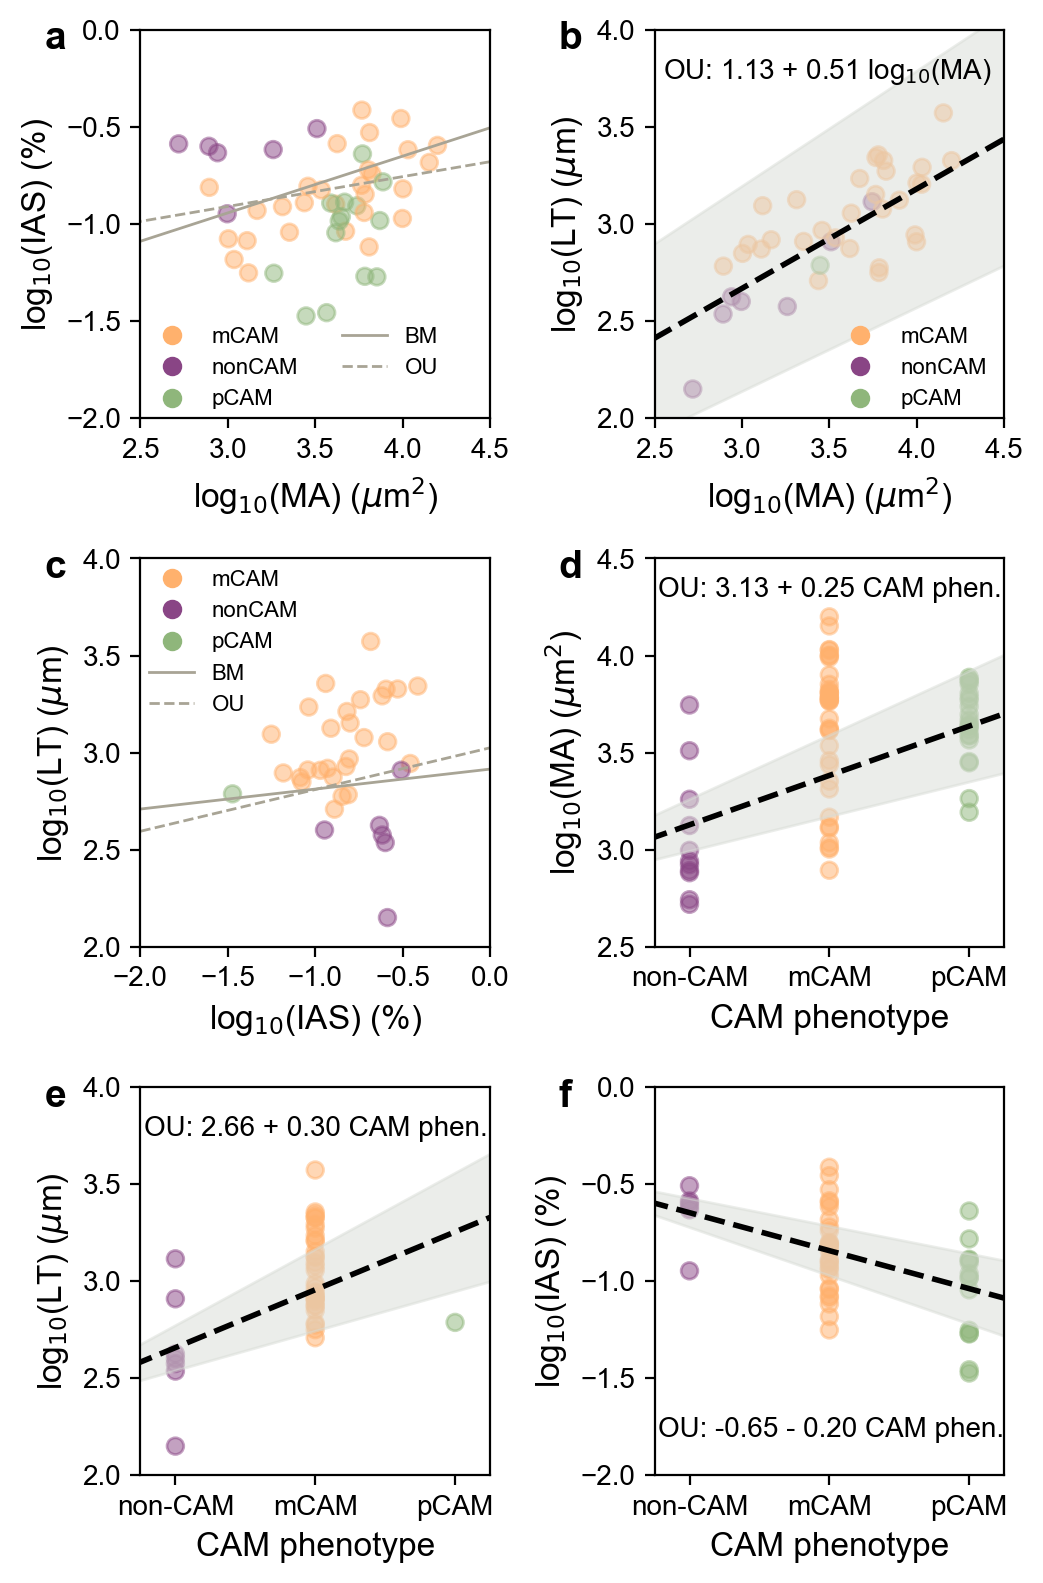

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8*2/3,8))

groups = pglsRes["PGLS_model"].unique()
for i,ax in enumerate(axes.flatten()):
        
    g = groups[i]
    resp = g.split()[0]
    pred = g.split()[-1]
    toPlot = pglsData[[resp,pred,"color"]].dropna()
    ax.scatter(toPlot[pred], toPlot[resp], color=toPlot["color"], alpha=0.5)
    domain = np.linspace(round(toPlot[pred].min()-0.5, 1), round(toPlot[pred].max()+0.5,1), num=100)
   
    curr = byGLS.get_group(g)
    ax.text(s=string.ascii_lowercase[i], x=-0.275, y=0.95, size=14, transform = ax.transAxes, weight="bold")
    
    if curr.sort_values(by="AIC", ascending=True)["Coef_1_pval"].values[0]< 0.05:
        bestModel = curr.sort_values(by="AIC", ascending=True).iloc[0]
        ax.fill_between(domain, 
                        (bestModel["Intercept"]-bestModel["Intercept_StdErr"]) + ((bestModel["Coef_1"]-bestModel["Coef_1_StdErr"])*domain), 
                        (bestModel["Intercept"]+bestModel["Intercept_StdErr"]) + ((bestModel["Coef_1"]+bestModel["Coef_1_StdErr"])*domain), color="xkcd:light grey", alpha=0.5)
        ax.plot(domain, bestModel["Intercept"] + (bestModel["Coef_1"]*domain), color="xkcd:black", linestyle=bestModel["ls"], linewidth=2)
    else:
        for j,row in curr.iterrows():
            ax.plot(domain, row["Intercept"] + (row["Coef_1"]*domain), color="xkcd:greyish", linestyle=row["ls"], linewidth=1, label=row["TraitEvoModel"])
        ax.legend(frameon=False, fontsize=10)

axes[0,1].text(s="OU: {:.2f} + {:.2f} log$_{{10}}$(MA)".format(
    pglsRes[(pglsRes["PGLS_model"]=="logLT ~ logMA") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][0],
    pglsRes[(pglsRes["PGLS_model"]=="logLT ~ logMA") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][1]),
    x=2.55, y=3.75, )
axes[1,1].text(s="OU: {:.2f} + {:.2f} CAM phen.".format(
    pglsRes[(pglsRes["PGLS_model"]=="logMA ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][0],
    pglsRes[(pglsRes["PGLS_model"]=="logMA ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][1]), 
    x=-0.225, y=4.3, )
axes[2,0].text(s="OU: {:.2f} + {:.2f} CAM phen.".format(
    pglsRes[(pglsRes["PGLS_model"]=="logLT ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][0],
    pglsRes[(pglsRes["PGLS_model"]=="logLT ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][1]), 
    x=-0.225, y=3.75, )
axes[2,1].text(s="OU: {:.2f} - {:.2f} CAM phen.".format(
    pglsRes[(pglsRes["PGLS_model"]=="logIAS ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][0],
    pglsRes[(pglsRes["PGLS_model"]=="logIAS ~ CAMphenoCat") & (pglsRes["TraitEvoModel"]=="OU")][["Intercept","Coef_1"]].values[0][1]*-1),
    x=-0.225, y=-1.8, )

axes[1,0].set_xticks(np.arange(-2,0.5,0.5))
axes[1,1].set_xticks([0,1,2])
axes[2,0].set_xticks([0,1,2])
axes[2,1].set_xticks([0,1,2])

axes[1,1].set_xticklabels(["non-CAM", "mCAM", "pCAM"])
axes[2,0].set_xticklabels(["non-CAM", "mCAM", "pCAM"])
axes[2,1].set_xticklabels(["non-CAM", "mCAM", "pCAM"])
    
axes[0,0].set_xlim(2.5,4.5)
axes[0,1].set_xlim(2.5,4.5)
axes[1,0].set_xlim(-2,0)
axes[1,1].set_xlim(-0.25, 2.25)
axes[2,0].set_xlim(-0.25, 2.25)
axes[2,1].set_xlim(-0.25, 2.25)

axes[0,0].set_ylim(-2,0)
axes[0,1].set_ylim(2,4)
axes[1,0].set_ylim(2,4)
axes[1,1].set_ylim(2.5,4.5)
axes[2,0].set_ylim(2,4)
axes[2,1].set_ylim(-2,0)

axes[0,0].set_xlabel(r"log$_{10}$(MA) ($\mu$m$^2$)", size=12)
axes[0,1].set_xlabel(r"log$_{10}$(MA) ($\mu$m$^2$)", size=12)
axes[1,0].set_xlabel(r"log$_{10}$(IAS) (%)", size=12)
axes[1,1].set_xlabel(r"CAM phenotype", size=12)
axes[2,0].set_xlabel(r"CAM phenotype", size=12)
axes[2,1].set_xlabel(r"CAM phenotype", size=12)

axes[0,0].set_ylabel(r"log$_{10}$(IAS) (%)",size=12)
axes[0,1].set_ylabel(r"log$_{10}$(LT) ($\mu$m)", size=12)
axes[1,0].set_ylabel(r"log$_{10}$(LT) ($\mu$m)", size=12)
axes[1,1].set_ylabel(r"log$_{10}$(MA) ($\mu$m$^2$)", size=12)
axes[2,0].set_ylabel(r"log$_{10}$(LT) ($\mu$m)", size=12)
axes[2,1].set_ylabel(r"log$_{10}$(IAS) (%)", size=12)

yellowMarker = Line2D([0], [0], marker='o', color=nonCAMcolor, label=r'nonCAM',linestyle="none")
purpleMarker = Line2D([0], [0], marker='o', color=nonpCAMcolor, label=r'mCAM',linestyle="none")
greenMarker = Line2D([0], [0], marker='o', color=pCAMcolor, label=r'pCAM',linestyle="none")
# axes[0,0].legend(handles=[yellowMarker, purpleMarker, greenMarker], frameon=False, fontsize=8, loc=(-0.05,0.0))
axes[0,1].legend(handles=[purpleMarker, yellowMarker, greenMarker], frameon=False, fontsize=8, loc=(0.5,0))
h,l = axes[1,0].get_legend_handles_labels()
axes[0,0].legend(handles=[purpleMarker, yellowMarker, greenMarker]+h, frameon=False, fontsize=8, loc=(0,0.0), ncol=2)
axes[1,0].legend(handles=[purpleMarker, yellowMarker, greenMarker]+h, frameon=False, fontsize=8, loc=(0,0.575))

plt.tight_layout()
# plt.savefig("../Figures/PGLS-Scatters.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

## Threshold model results

In [27]:
maThresh = pd.read_csv("../Results/maThreshPar.csv")
iasThresh = pd.read_csv("../Results/iasThreshPar.csv")
ltThresh = pd.read_csv("../Results/ltThreshPar.csv")

ngen = 10e+06
burnin = 0.2*ngen
maThresh = maThresh[maThresh["gen"]>burnin]
iasThresh = iasThresh[iasThresh["gen"]>burnin]
ltThresh = ltThresh[ltThresh["gen"]>burnin]

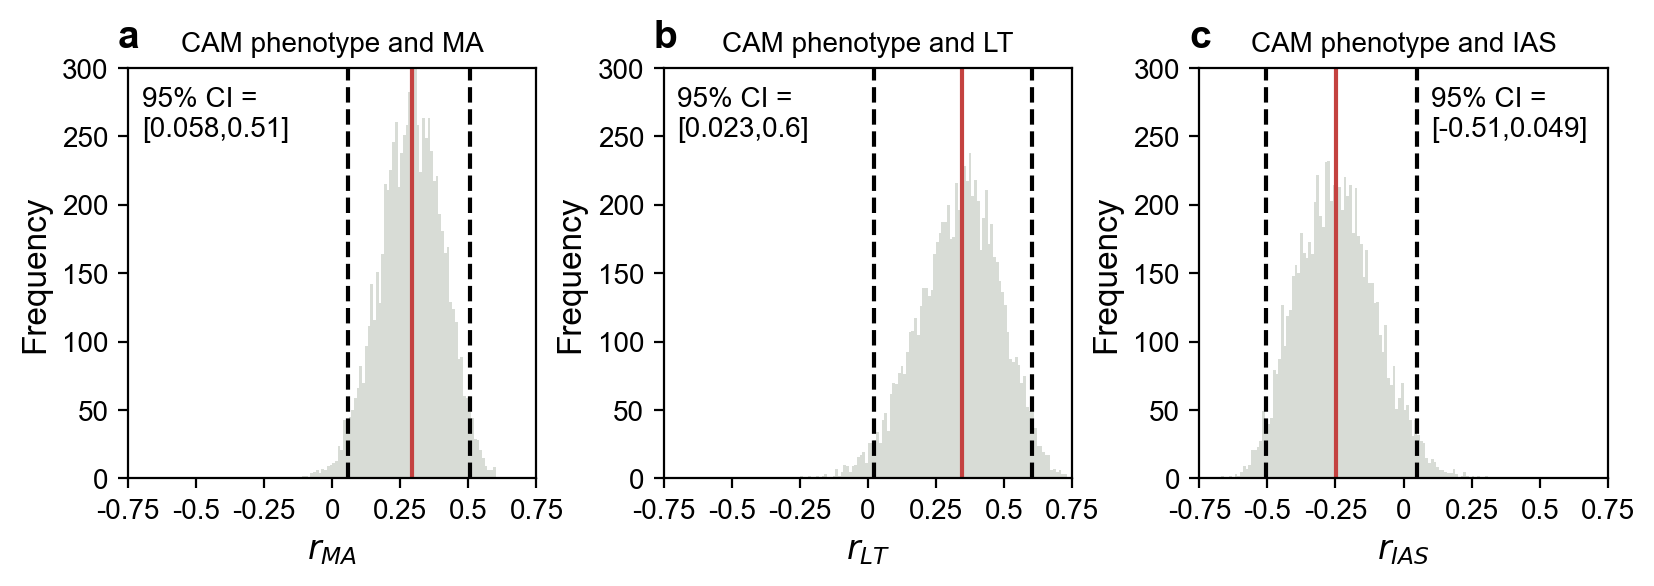

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8/3))

for i,df in enumerate([maThresh, ltThresh, iasThresh]):
    ax[i].hist(df["r"], bins=np.arange(-1,1.01,0.01), color="xkcd:light grey")
    
    ax[i].vlines(x=np.quantile(df["r"], 0.025), ymin=0, ymax=2500, linestyle="--", color="xkcd:black")
    ax[i].vlines(x=np.quantile(df["r"], 0.975), ymin=0, ymax=2500, linestyle="--", color="xkcd:black")    
    ax[i].vlines(x=np.quantile(df["r"], 0.5), ymin=0, ymax=2500, linestyle="-", color="xkcd:reddish")

    ax[i].set_xticks(np.arange(-0.75,1,0.25))
    ax[i].set_xticklabels([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
    ax[i].set_xlim(-0.75,0.75)
    ax[i].set_ylim(0,300)
    ax[i].set_ylabel("Frequency", size=12)
    x = -0.7
    if i==2: x=0.1
    ax[i].text(s="95% CI =\n[{:1.2},{:1.2}]".format(np.quantile(df["r"], 0.025), np.quantile(df["r"], 0.975)), x=x, y=250)
    ax[i].text(s=string.ascii_lowercase[i], x=-0.025, y=1.05, size=14, transform = ax[i].transAxes, weight="bold")


ax[0].set_title("CAM phenotype and MA", size=10)
ax[1].set_title("CAM phenotype and LT", size=10)
ax[2].set_title("CAM phenotype and IAS", size=10)

ax[0].set_xlabel("$r_{MA}$", size=12)
ax[1].set_xlabel("$r_{LT}$", size=12)
ax[2].set_xlabel("$r_{IAS}$", size=12)

plt.tight_layout(pad=-0.25)
# plt.savefig("../Figures/threshBayesCorrelations.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")